<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/PLSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import math
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG = True

# PLSA

The paper : https://arxiv.org/ftp/arxiv/papers/1301/1301.6705.pdf

> #### We will use **Probabilistic latent semantic analysis** to extract the topics from a corpus of documents. We'll use  a preprocessed dataset of documents from the Associated Press.




Before diving into the code let's talk about the model we're using here. <br>The PLSA model is a probabilistic model over a corpus. It identifies *each document as a mixture of topics* (latent or unobserved variables), and *each topic as a multinomial distribution* over the words in the vocabulary. Below is a sketch of the model:
$$ d \rightarrow z \rightarrow w $$
where $d$ is a document in the corpus, $z$ is the latent variable topic and $w$ is the random variable word. 
<br>
**The main drawback of this approach**? The inability to generalise to new documents, which derives from the fact that this model does not take into account a generative hypothesis for documents as well (look for LDA to see a complete generative model).
<br>
<br>
Enough with the presentation, let's get started. 


## Data loading and pre-processing 

In [2]:
# Note : I have uploaded the data on the hosted runtime, and un-packed it with the folliwing 
# commands. You need the data in your execution directory to be able to run these lines.
!ls

associated-press  associated-press.tar	sample_data


In [0]:
! gunzip associated-press.tar.gz && tar -xvf associated-press.tar

In [4]:
!ls && ls associated-press

associated-press  associated-press.tar	sample_data
doc.dat  test.dat  train.dat  voc.dat


In [0]:
# The data is organised it 4 different sets 
# We'll open the training set now
train_docs = []
with open("associated-press/train.dat", 'r') as f:
    for line in f.readlines():
        train_docs.append(line)

In [4]:
train_docs[1]

'work posit reach reach peopl year thought million million million presid govern year year first percent state appear abl time billion told resid complet day develop made made made made wednesday wednesday jerusalem investig compani compani compani compani parti parti group group anonym effect financ payment make spokesman isra isra think assur rappaport rappaport rappaport rappaport rappaport rappaport rappaport construct foreign foreign foreign foreign offici offici offici offici offici offici offici offici public take gener septemb septemb believ polit partner ask spoke earlier go oil oil oil oil oil oil war minist minist sell promi say came deni deni man specif mention attorney attorney person relay offer sale sale submit inc idea friend friend put acknowledg speak improp vice israel israel thing border border ministri ministri ministri mee mee mee secret come iii think refer close close shimon possibl relat focu handl handl repr wrongdo project pere pere pere pere pere pere pere p

In [0]:
# As we can see the text has already been pre-processed (tokenization, stemming)
# Now we'll transform each dataset in a term-document matrix 
vectorizer = CountVectorizer(vocabulary=None)
train_X = vectorizer.fit_transform(train_docs)
# by defaul the Vectorizer builds a sparse matrix
# being the dataset relatively small we can afford working 
# with the entire matrix in memory 
train_X = train_X.toarray()

In [6]:
train_X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
# as you can see the matrix is very sparse 
train_X.shape

(2000, 6756)

In [8]:
total_entries = train_X.shape[0]*train_X.shape[0]
observed_entries = sum(sum(train_X))
sparseness_factor = observed_entries/total_entries
sparseness_factor

0.097353

In [0]:
n_docs = train_X.shape[0]
n_terms = train_X.shape[1]

## Model building 



> One mln dollar question: how many topics will be covered in 2k documents from the associated press?



In [0]:
# The first, and also the hardest modeling choice to make here is the 
# number of topics, which must be known before-hand.
# Of course, we can use cross-validation to sort out the best option,
# but for the sake of the implementation we'll now set it to an 
# arbitrary constant. 
n_topics = 20

#### Here we initialise our model.

<br> 
*Components*<br>
The PLSA model is made of 3 matrices: $U$, $V$ and $Q$. 
<br>The matrix $U$ relates the documents to the topics: $u_{i}$ is the row vector that expresses the mixture components in the $i$-th document. Similarly, the matrix $V$ relates the words to the topics: $v_{j}$ is the row vector whose entries express the probability of the $j$-th word to have been generated by the relative topic. The underlying assumption is that each word has been generated by only one topic. Finally the matrix $Q$ contains the posterior probabilities for each topic: the entry $q_{ijz}$ expresses the probability that the $j$-th word in the $i$-th document belongs to the topic $z$.
<br><br>
*Constrants*<br>
The initialisation of the matrices has to take into account the constraints that they have to satisfy. Each row of the above matrices must sum up to one and each entry must be non-negative, since the vectors in these matrices are probability vectors.

In [0]:
def init(n_topics, n_docs, n_words):
  U = np.random.rand(n_docs,n_topics)
  V = np.random.rand(n_words, n_topics)
  Q = np.random.rand(n_docs,n_words,n_topics)
  # Constraint 
  U = U/np.sum(U,axis=1).reshape(-1,1)
  V = V/np.sum(V,axis=1).reshape(-1,1)
  Q = Q/np.sum(Q,axis=2).reshape(Q.shape[0],-1,1)
  return U,V,Q

### EM Inference 
Implementing the **Expectation-Maximization** algorithm applied to PLSA. <br>
We are using the Expectation-Maximization algo to maximize an otherwise intractable distribution. More specifically we are maximing the lower bound obtained via Jensen inequality.

***Expectation step***<br>
Here we update our posterior probabilities according to the current estimates for the matrices U and V. 

In [0]:
def compute_expectation(U,V,Q):
  # a constant to avoid dividing by 0 
  eps=1e-2
  # update the matrix
  Q = np.einsum('ik,jk -> ijk', U,V)
  denominator = np.maximum(eps,np.einsum('ik,jk -> ij', U,V))
  Q = Q/denominator.reshape(Q.shape[0],-1,1)
  # check simplex constraint
  assert np.all(np.einsum('ijk -> ij', Q) - 1 < eps), "The entries do not sum up to 1"
  # check the non-negativity constraint
  assert np.any(Q<0) == False, "There are negative entries"
  return Q

***Maximization step***<br>
Here we update new estimates for the matrices U and V, according to the responsibilities we've computed before

In [0]:
def compute_maximization(U,V,Q,X):
  # a constant to avoid dividing by 0 
  eps=1e-2

  U = np.einsum('ij, ijz -> iz', X,Q)
  denominator = np.maximum(eps,np.einsum('ij -> i', X))
  U = U/denominator.reshape(-1,1)
  # check simplex constraint
  assert np.all(np.einsum('ik -> i', U) - 1 < eps), "The entries do not sum up to 1"
  # check the non-negativity constraint
  assert np.any(U<0) == False, "There are negative entries"

  V = np.einsum('ij, ijz -> jz', X,Q)
  denominator = np.maximum(eps,np.einsum('ij , ijz-> j', X, Q))
  V = V/denominator.reshape(-1,1)
  # check simplex constraint
  assert np.all(np.einsum('jk -> j', V) - 1 < eps), "The entries do not sum up to 1"
  # check the non-negativity constraint
  assert np.any(V<0) == False, "There are negative entries"

  return U,V


Here are some utility functions that we'll be used in the training loop

In [0]:
def compute_lower_bound(U, V, Q, X): 
  # a constant to avoid dividing by 0 
  eps=1e-4
  lb = np.einsum('ijk,ik -> ij', Q,np.log(np.maximum(U,eps))) \
      + np.einsum('ijk,jk -> ij', Q,np.log(np.maximum(V,eps))) \
      - np.einsum('ijk,ijk -> ij', Q,np.log(np.maximum(Q,eps)))
  
  lb = np.einsum('ij,ij -> ',X,lb)

  return lb

def compute_loglikelihood(U, V, X): 
  # a constant to avoid dividing by 0 
  eps=1e-4
  
  ll = np.einsum('ik,jk -> ij', U,V)
  ll = np.einsum('ij,ij -> ',X,np.log(np.maximum(ll,eps)))

  return ll

### The training loop 

In [0]:
training = True

In [0]:
from datetime import datetime

In [33]:
start = datetime.now()
if training:
  U,V,Q = init(n_topics, n_docs, n_terms)
  n_itrs = 25 # number of iterations 
  lowerbounds = np.zeros(n_itrs)
  loglikelihoods = np.zeros(n_itrs)
  for i in range(n_itrs):
      print("EM iteration {}".format(i))
      Q = compute_expectation(U, V, Q)
      U, V = compute_maximization(U, V, Q, train_X)
      lowerbounds[i] = compute_lower_bound(U,V,Q,train_X)
      loglikelihoods[i] = compute_loglikelihood(U,V,train_X)
end = datetime.now()
duration = end-start
print("Total time = ", duration)

EM iteration 0
EM iteration 1
EM iteration 2
EM iteration 3
EM iteration 4
EM iteration 5
EM iteration 6
EM iteration 7
EM iteration 8
EM iteration 9
EM iteration 10
EM iteration 11
EM iteration 12
EM iteration 13
EM iteration 14
EM iteration 15
EM iteration 16
EM iteration 17
EM iteration 18
EM iteration 19
EM iteration 20
EM iteration 21
EM iteration 22
EM iteration 23
EM iteration 24


AttributeError: ignored

In [34]:
rint("Total time = ", duration)

Total time =  0:05:15.502507


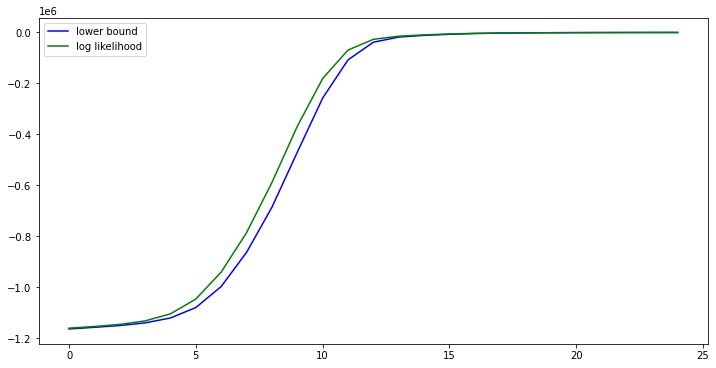

In [41]:
# Now some plotting to make us all happy to be here 
iters = np.arange(n_itrs)
plt.figure(figsize=(12,6))
plt.plot(iters,lowerbounds,'b', label='lower bound')
plt.plot(iters,loglikelihoods,'g', label="log likelihood")
plt.legend()
plt.show()

## Results analysis

Now that we finally got our results for ```n_topics = 100``` we can analyse them, by looking, for example, at the most probable and the least probable words for each topic.



In [0]:
from operator import itemgetter 

n_top = 5 # 5 most probable
n_low = 5 # 5 least probable
names = vectorizer.get_feature_names() # get back the words associated with each index 
sorted_idx = np.argsort(V, axis=0)

def show_topic(topic_idx):
  words_top = sorted_idx[-6:-1,topic_idx]
  words_bottom = sorted_idx[0:5,topic_idx]
  print("TOPIC ", topic_idx)
  print("5 most probable words:")
  print(itemgetter(*words_top)(names))
  print("5 least probable words:")
  print(itemgetter(*words_bottom)(names))

In [77]:
for i in range(n_topics):
  print("--------")
  show_topic(i)

--------
TOPIC  0
5 most probable words:
('vega', 'tenor', 'intersect', 'chart', 'gunter')
5 least probable words:
('aaron', 'pet', 'pesticid', 'pest', 'pessim')
--------
TOPIC  1
5 most probable words:
('oat', 'schroeder', 'cholesterol', 'popey', 'quaker')
5 least probable words:
('aaron', 'peru', 'persuad', 'perspect', 'personnel')
--------
TOPIC  2
5 most probable words:
('edgar', 'literari', 'rambo', 'wagner', 'stallon')
5 least probable words:
('aaron', 'pig', 'pierr', 'piec', 'pie')
--------
TOPIC  3
5 most probable words:
('filipino', 'filibust', 'file', 'fijian', 'firstclass')
5 least probable words:
('aaron', 'platoon', 'platform', 'plate', 'plastic')
--------
TOPIC  4
5 most probable words:
('video', 'broaden', 'raton', 'boca', 'blockbust')
5 least probable words:
('aaron', 'plagu', 'placement', 'place', 'pizza')
--------
TOPIC  5
5 most probable words:
('absent', 'meager', 'appl', 'puett', 'kephart')
5 least probable words:
('aaron', 'packag', 'pack', 'pacif', 'pace')
------